# Preprocesamiento

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.stats import sigma_clip

import scipy.stats.stats as st
import scipy.stats as ss
from __future__ import division
import pandas as pd
from scipy.optimize import leastsq


pc_name='nico'

def sigma_clip(tiempo, mag, err, mean, sigma_clip):
    index = mag <= mean+sigma_clip
    mag2=  mag[index]
    tiempo2 = tiempo[index]
    err2 = err[index]
    index = mag2 >= mean-sigma_clip
    return tiempo2[index], mag2[index], err2[index]
 
def getInverse(arreglo):
    salida = []
    for elemento in arreglo:
        try:
            salida.append([1/elemento])
        except ZeroDivisionError:
            print "error"
    
    return salida

def Beyond1std(arreglo, weigth_mean, standar_dev):
    numerator = 0
    denominator = len(arreglo)
    for elemento in arreglo:
        if abs(elemento-weigth_mean) >= standar_dev:
            numerator += 1
    
    return numerator/denominator

def slope_trend(arreglo):
    N = len(arreglo) - 1
    for i in range(N):
        num = 0
        if (arreglo[i+1]-arreglo[i]) >= 0:
            num += 1
        
    return num/N  

def get_stetson_k(mag, avg, err):
    residual = (mag - avg) / err
    stetson_k = np.sum(np.fabs(residual)) \
                / np.sqrt(np.sum(residual * residual)) / np.sqrt(len(mag))

    return stetson_k

def get_eta(mag, std):
    diff = mag[1:] - mag[:len(mag) - 1]
    eta = np.sum(diff * diff) / (len(mag) - 1.) / std / std

    return eta

def get_cusum(mag, weighted_mean, weighted_std):
    c = np.cumsum(mag - weighted_mean) / len(mag) / weighted_std

    return np.max(c) - np.min(c)


def residuals(pars, x, y, order):
    """
    Residual of Fourier Series.
    Parameters
    ----------
    pars : array_like
        Fourier series parameters.
    x : array_like
        An array of date.
    y : array_like
        An array of true values to fit.
    order : int
        An order of Fourier Series.
    """

    return y - fourier_series(pars, x, order)

def fourier_series(pars, x, order):
    """
    Function to fit Fourier Series.
    Parameters
    ----------
    x : array_like
        An array of date divided by period. It doesn't need to be sorted.
    pars :  array_like
        Fourier series parameters.
    order : int
        An order of Fourier series.
    """

    sum = pars[0]
    for i in range(order):
        sum += pars[i * 2 + 1] * np.sin(2 * np.pi * (i + 1) * x) \
               + pars[i * 2 + 2] * np.cos(2 * np.pi * (i + 1) * x)

    return sum

def fourier(date, mag, period, order):
    
    # Initial guess of Fourier coefficients.
    p0 = np.ones(order * 2 + 1)
    date_period = (date % period) / period
    p1, success = leastsq(residuals, p0,
                          args=(date_period, mag, order))
    
    return p1, success

def slope_percentile(date, mag):
    """
    Return 10% and 90% percentile of slope.
    Parameters
    ----------
    date : array_like
        An array of phase-folded date. Sorted.
    mag : array_like
        An array of phase-folded magnitudes. Sorted by date.
    Returns
    -------
    per_10 : float
        10% percentile values of slope.
    per_90 : float
        90% percentile values of slope.
    """

    date_diff = date[1:] - date[:len(date) - 1]
    mag_diff = mag[1:] - mag[:len(mag) - 1]

    # Remove zero mag_diff.
    index = np.where(mag_diff != 0.)
    date_diff = date_diff[index]
    mag_diff = mag_diff[index]

    # Derive slope.
    slope = date_diff / mag_diff

    percentile_10 = np.percentile(slope, 10.)
    percentile_90 = np.percentile(slope, 90.)

    return percentile_10, percentile_90

def half_mag_amplitude_ratio(mag, avg, weight):
    """
    Return ratio of amplitude of higher and lower magnitudes.
    A ratio of amplitude of higher and lower magnitudes than average,
    considering weights. This ratio, by definition, should be higher
    for EB than for others.
    Parameters
    ----------
    mag : array_like
        An array of magnitudes.
    avg : float
        An average value of magnitudes.
    weight : array_like
        An array of weight.
    Returns
    -------
    hl_ratio : float
        Ratio of amplitude of higher and lower magnitudes than average.
    """

    # For lower (fainter) magnitude than average.
    index = np.where(mag > avg)
    lower_weight = weight[index]
    lower_weight_sum = np.sum(lower_weight)
    lower_mag = mag[index]
    lower_weighted_std = np.sum((lower_mag
                                 - avg) ** 2 * lower_weight) / \
                         lower_weight_sum

    # For higher (brighter) magnitude than average.
    index = np.where(mag <= avg)
    higher_weight = weight[index]
    higher_weight_sum = np.sum(higher_weight)
    higher_mag = mag[index]
    higher_weighted_std = np.sum((higher_mag
                                  - avg) ** 2 * higher_weight) / \
                          higher_weight_sum

    # Return ratio.
    return np.sqrt(lower_weighted_std / higher_weighted_std)


exito = [1,2,3,4]

def folded_curve(mag, date, period):
    
    phase_folded_date = date % (period * 2.)
    sorted_index = np.argsort(phase_folded_date)

    folded_date = phase_folded_date[sorted_index]
    folded_mag = mag[sorted_index]
    
    return folded_date, folded_mag

    
#### directory debe terminar en "/", o filename empezar en "/"
def features (directory, filename):  
    date, Red_m_0 , Red_err_0 , Blue_m_0 , Blue_err_0 = np.loadtxt(directory+filename+'.time', usecols=(0, 1, 2, 3, 4), unpack = True)
    period = np.loadtxt(directory+filename+'.dat')
    label = ID_labels [filename]
    
    ### Eliminar spikes
    ### RED
    index_R = Red_m_0 < 99.999
    Date_red = date[index_R]
    Red_m = Red_m_0[index_R]
    Red_err = Red_err_0[index_R]
    
    ### BLUE 
    index_B = Blue_m_0 < 99.999
    Date_blue = date[index_B]
    Blue_m = Blue_m_0[index_B]
    Blue_err = Blue_err_0[index_B]
    
    ### Promedios
    Red_mean = np.mean(Red_m)
    Blue_mean = np.mean(Blue_m)
    
    ###Standar Deviation
    Red_std = np.std(Red_m)
    Blue_std = np.std(Blue_m)
    
    Date_red, Red_m, Red_err = sigma_clip(Date_red, Red_m, Red_err, Red_mean, 3*Red_std)
    Date_blue, Blue_m, Blue_err = sigma_clip(Date_blue, Blue_m, Blue_err, Blue_mean, 3*Blue_std)
    

    ####################### FEATURES ###########################
    ############################################################
    
    ### Medianas (no es una característica) 
    Red_median = np.median(Red_m)
    Blue_median = np.median(Blue_m)
    
    Red_weight = 1. / Red_err
    Red_weighted_sum = np.sum(Red_weight)
    Red_weighted_mean = np.sum(Red_m * Red_weight) / Red_weighted_sum
    Red_weighted_std = np.sqrt(np.sum((Red_m - Red_weighted_mean) ** 2  * Red_weight) / Red_weighted_sum)
    
    Blue_weight = 1. / Blue_err
    Blue_weighted_sum = np.sum(Blue_weight)
    Blue_weighted_mean = np.sum(Blue_m * Blue_weight) / Blue_weighted_sum
    Blue_weighted_std = np.sqrt(np.sum((Blue_m - Blue_weighted_mean) ** 2  * Blue_weight) / Blue_weighted_sum)
    
    ### Magnitude Ratio
    max_R = max(Red_m)
    min_R = min(Red_m)
    Red_MagRatio = (max_R - np.median(Red_m))/(max_R - min_R)

    max_B = max(Blue_m)
    min_B = min(Blue_m)
    Blue_MagRatio = (max_B - np.median(Blue_m))/(max_B - min_B)

    ### Amplitud
    Red_amplitude = (max_R - min_R)*0.5
    Blue_amplitude = (max_B - min_B)*0.5
    
    ### Skewness
    Red_skew = st.skew(Red_m)
    Blue_skew = st.skew(Blue_m)
    
    ## Kurtosis
    Red_kurt = ss.kurtosis(Red_m)
    Blue_kurt = ss.kurtosis(Blue_m)
    
    # Quartil 31
    Red_quartile31 = np.percentile(Red_m, 75) - np.percentile(Red_m, 25)
    Blue_quartile31 = np.percentile(Blue_m, 75) - np.percentile(Blue_m, 25)
    
    ## Stetson_k
    Red_stetson = get_stetson_k(Red_m, Red_median, Red_err)
    Blue_stetson = get_stetson_k(Blue_m, Blue_median, Blue_err)
    
    ### Eta
    Red_eta = get_eta(Red_m, Red_std)
    Blue_eta = get_eta(Blue_m, Blue_std)
    
    ## Cusum
    Red_cusum = get_cusum(Red_m, Red_weighted_mean, Red_weighted_std)
    Blue_cusum = get_cusum(Blue_m, Blue_weighted_mean, Blue_weighted_std)
    
    ## Shapiro
    shapiro_red = ss.shapiro(Red_m)
    Red_shapiro = shapiro_red[0]
    
    shapiro_blue = ss.shapiro(Blue_m)
    Blue_shapiro = shapiro_blue[0]
    
    ##Beyond1std
    Red_B1std = Beyond1std(Red_m, Red_mean, Red_std)
    Blue_B1std = Beyond1std(Blue_m, Blue_mean, Blue_std)
    
    ##Slope_trend  BORRAR PORQUE ES MALA CARACTERISTICA
    #Red_slope_trend = slope_trend(Red_m)
    #Blue_slope_trend = slope_trend(Blue_m)
    
    Red_hl_amp_ratio = half_mag_amplitude_ratio(Red_m, Red_median, Red_weight)
    Blue_hl_amp_ratio = half_mag_amplitude_ratio(Blue_m, Blue_median, Blue_weight)
    
    ##B-R
    B_R = Blue_mean - Red_mean
    
    

    #### PERIODICAS RED
    
    Red_folded_date, Red_folded_mag = folded_curve(Red_m, Date_red, period)
    
    # phase Eta
    Red_phase_eta = get_eta(Red_folded_mag, Red_weighted_std)

    # Slope percentile.
    Red_slope_per10, Red_slope_per90 = slope_percentile(Red_folded_date, Red_folded_mag)

    # phase Cusum
    Red_phase_cusum = get_cusum(Red_folded_mag, Red_weighted_mean, Red_weighted_std)
        
    
    p1, success = fourier(Date_red, Red_m, period, 3)
    
    if success not in exito:
        print "Fourier Failed"
        
    Red_amplitude_f = np.sqrt(p1[1] ** 2 + p1[2] ** 2)
    Red_r21 = np.sqrt(p1[3] ** 2 + p1[4] ** 2) / Red_amplitude_f
    Red_r31 = np.sqrt(p1[5] ** 2 + p1[6] ** 2) / Red_amplitude_f
    Red_f_phase = np.arctan(-p1[1] / p1[2])
    Red_phi21 = np.arctan(-p1[3] / p1[4]) - 2. * Red_f_phase
    Red_phi31 = np.arctan(-p1[5] / p1[6]) - 3. * Red_f_phase
    
    #### PERIODICAS BLUE
    
    Blue_folded_date, Blue_folded_mag = folded_curve(Blue_m, Date_blue, period)
    
    # phase Eta
    Blue_phase_eta = get_eta(Blue_folded_mag, Blue_weighted_std)

    # Slope percentile.
    Blue_slope_per10, Blue_slope_per90 = slope_percentile(Blue_folded_date, Blue_folded_mag)

    # phase Cusum
    Blue_phase_cusum = get_cusum(Blue_folded_mag, Blue_weighted_mean, Blue_weighted_std)
        
    
    p1, success = fourier(Date_blue, Blue_m, period, 3)
    
    if success not in exito:
        print "Fourier Failed"
        
    Blue_amplitude_f = np.sqrt(p1[1] ** 2 + p1[2] ** 2)
    Blue_r21 = np.sqrt(p1[3] ** 2 + p1[4] ** 2) / Blue_amplitude_f
    Blue_r31 = np.sqrt(p1[5] ** 2 + p1[6] ** 2) / Blue_amplitude_f
    Blue_f_phase = np.arctan(-p1[1] / p1[2])
    Blue_phi21 = np.arctan(-p1[3] / p1[4]) - 2. * Blue_f_phase
    Blue_phi31 = np.arctan(-p1[5] / p1[6]) - 3. * Blue_f_phase
    
    
    
    #return np.array([[label, Red_mean, Red_std, Red_MagRatio, Red_amplitude, Red_skew, Red_eta, Red_B1std, Red_slope_trend,
    #                  Blue_mean, Blue_std, Blue_MagRatio, Blue_amplitude, Blue_skew, Blue_eta, Blue_B1std, Blue_slope_trend, B_R, period]])

    #return np.array([[label, Blue_mean, Blue_std, Blue_MagRatio, Blue_amplitude, Blue_skew, Blue_kurt, Blue_quartile31, Blue_stetson, 
    #                  Blue_eta, Blue_cusum, Blue_shapiro, Blue_B1std]])
    
    #return np.array([[label, Red_phase_eta, Red_slope_per10, Red_slope_per90,Red_phase_cusum, \
    #                  Red_amplitude, Red_r21, Red_r31, Red_f_phase, Red_phi21, Red_phi31]])


    return np.array([[label,Red_weighted_mean,Red_weighted_std,Red_MagRatio,Red_amplitude,\
                      Red_skew,Red_kurt, Red_quartile31, Red_stetson, Red_eta, Red_cusum,\
                      Red_shapiro, Red_B1std, Red_hl_amp_ratio, \
                      Red_phase_eta, Red_slope_per10, Red_slope_per90,Red_phase_cusum, \
                      Red_amplitude_f, Red_r21, Red_r31, Red_f_phase, Red_phi21, Red_phi31, \
                      Blue_weighted_mean, Blue_weighted_std, Blue_MagRatio, Blue_amplitude,\
                      Blue_skew,Blue_kurt, Blue_quartile31, Blue_stetson, Blue_eta, Blue_cusum,\
                      Blue_shapiro, Blue_B1std,Blue_hl_amp_ratio,\
                      Blue_phase_eta, Blue_slope_per10, Blue_slope_per90,Blue_phase_cusum, \
                      Blue_amplitude_f, Blue_r21, Blue_r31, Blue_f_phase, Blue_phi21, Blue_phi31, \
                      B_R, period]])



# Diccionario con labels

In [2]:
ID_labels = {}

direccion_ceph = 'CEPH_catalog_crossmatch_eros_ogle.csv'
etiquetas_ceph = np.genfromtxt(direccion_ceph, 'string', delimiter=',')

direccion_RRL = 'RRL_catalog_crossmatch_eros_ogle.csv'
etiquetas_RRL = np.genfromtxt(direccion_RRL, 'string', delimiter=',')

direccion_EB = 'EB_catalog_crossmatch_eros_ogle.csv'
etiquetas_EB = np.genfromtxt(direccion_EB, 'string', delimiter=',')

ogle_id_ceph = etiquetas_ceph[1:len(etiquetas_ceph), 1]
labels_ceph = etiquetas_ceph[1:len(etiquetas_ceph), 4]

ogle_id_RRL = etiquetas_RRL[1:len(etiquetas_RRL), 1]
labels_RRL = etiquetas_RRL[1:len(etiquetas_RRL), 4]

ogle_id_EB = etiquetas_EB[1:len(etiquetas_EB), 1]
labels_EB = etiquetas_EB[1:len(etiquetas_EB), 4]


for indice in range(len(ogle_id_ceph)):
    ID_labels[ ogle_id_ceph[indice] ] = labels_ceph[indice]
    
for indice in range(len(ogle_id_RRL)):
    ID_labels[ ogle_id_RRL[indice] ] = labels_RRL[indice]

for indice in range(len(ogle_id_EB)):
    ID_labels[ ogle_id_EB[indice] ] = labels_EB[indice]

# Creación de base de datos con características

In [31]:
import os

names = []
row_counter = 0
directory1 = 'dataset/'
stars_not_found = 0

clases = os.listdir(directory1)
count = 0

for clase in clases:
    directory2 = directory1+clase+"/"
    subclases = os.listdir(directory2)
    print "Starting with a new folder"
    for carpeta in subclases:
        directory=directory2+carpeta+"/"
        for name in os.listdir(directory):
            if name.endswith(".time"):
                name_2 = (os.path.splitext(name)[0])
                if row_counter == 0 :
                    features_matrix = features(directory,name_2)
                else:
                    try:
                        features_matrix = np.concatenate((features_matrix, features(directory, name_2)), axis = 0)
                    except (KeyError, IOError) as e:
                        stars_not_found += 1
                row_counter += 1
                if ((count%1000) == 0):
                    print count
                count = count + 1 

print "Estrellas no encontradas en el cross-match:"
print stars_not_found



import pickle
nombre_archivo = "final_features.p"
pickle.dump( features_matrix , open( nombre_archivo , "wb" ) )

# caracteristicas.p es la versión inicial, con carcterísticas en el rojo y azul
# newfeatures1.p posee kurtosis, quartil 31, Stetson_k, Eta y Cusum agregados, pero sólo en el canal rojo
# azulFeatures.p posee las mismas que newfeatures1.p, pero en el azul, y sin B-R y periodo, tampoco slope_trend: 
#    EN ESTE ULTIMO SE INCLUYÓ EL LABEL PARA VER SI LAS CARACTERISTICAS ESTABAN EN EL MISMO ORDEN

# red_periodics posee: [[label, Red_phase_eta, Red_slope_per10, Red_slope_per90,Red_phase_cusum, \
                      #Red_amplitude, Red_r21, Red_r31, Red_f_phase, Red_phi21, Red_phi31]]) 

Starting with a new folder
0
1000
2000
Starting with a new folder
3000
4000
5000
6000
7000
8000
9000
10000
11000
Starting with a new folder
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
Estrellas no encontradas en el cross-match:
1047


# Separabilidad clases (EB, Cefeidas, RR Lyrae)

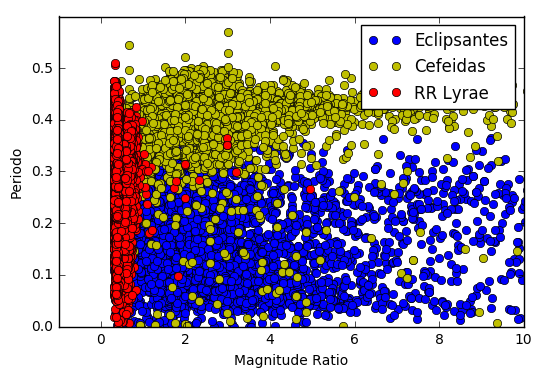

In [10]:
import pickle
caracteristicas = pickle.load( open( "final_features.p", "rb" ) )

feature_1 = 48
feature_2 = 35

RR_feature_1 = []
RR_feature_2 = []

EB_feature_1 = []
EB_feature_2 = []

Ceph_feature_1 = []
Ceph_feature_2 = []

for j in range(len(caracteristicas[:,0])):
    if caracteristicas[j,0][0] == 'R':
        RR_feature_1.append(caracteristicas[j,feature_1])
        RR_feature_2.append(caracteristicas[j,feature_2])

    elif caracteristicas[j,0][0] == 'E':
        EB_feature_1.append(caracteristicas[j,feature_1])
        EB_feature_2.append(caracteristicas[j,feature_2])
    else:
        Ceph_feature_1.append(caracteristicas[j,feature_1])
        Ceph_feature_2.append(caracteristicas[j,feature_2])

        #[label, Red_mean, Red_std, Red_MagRatio, Red_amplitude, Blue_mean, Blue_std, 
        #Blue_MagRatio, Blue_amplitude, period]

p1, = plt.plot(EB_feature_1, EB_feature_2 , 'o', color='b')
p2, = plt.plot(Ceph_feature_1, Ceph_feature_2 , 'o', color='y') ##g^
p3, = plt.plot(RR_feature_1, RR_feature_2 , 'o', color='r')
plt.axis([-1,10, 0, .6])
plt.xlabel("Magnitude Ratio")
plt.ylabel("Periodo")

plt.legend([ p1, p2, p3], ["Eclipsantes" ,"Cefeidas", "RR Lyrae"])
            

# RR Lyrae Subclases

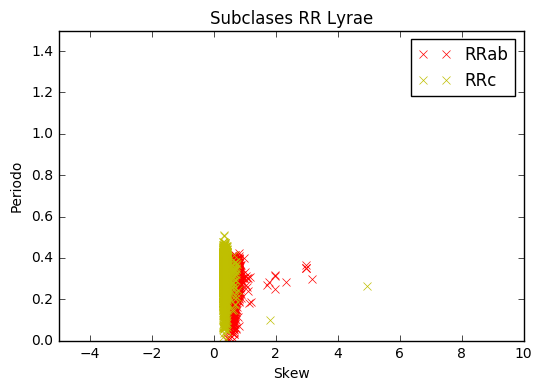

In [11]:
import pickle
caracteristicas = pickle.load( open( "final_features.p", "rb" ) )

feature_1 = 48
feature_2 = 35

RRab_feature_1 = []
RRab_feature_2 = []


RRc_feature_1 = []
RRc_feature_2 = []
counter = 0
RRab= 0
RRc = 0
for j in range(len(caracteristicas[:,0])):
    if caracteristicas[j,0][0] == 'R':
        if caracteristicas[j,0] == "RRab":
            RRab_feature_1.append(caracteristicas[j,feature_1])
            RRab_feature_2.append(caracteristicas[j,feature_2])
            RRab += 1
            
        elif caracteristicas[j,0] == "RRc":
            RRc_feature_1.append(caracteristicas[j,feature_1])
            RRc_feature_2.append(caracteristicas[j,feature_2])
        else:
            counter += 1

ab, = plt.plot(RRab_feature_1, RRab_feature_2 , 'x', color='r')
c, = plt.plot(RRc_feature_1, RRc_feature_2 , 'x', color='y') 
plt.axis([-5,10, 0, 1.5])
plt.xlabel("Skew")
plt.ylabel("Periodo")
plt.legend([ ab, c], ["RRab","RRc"])
plt.title("Subclases RR Lyrae")
        #[label, Red_mean, Red_std, Red_MagRatio, Red_amplitude, Blue_mean, Blue_std, 
        #Blue_MagRatio, Blue_amplitude, period]
            

# SEPARABILIDAD TODAS LAS CLASES

In [15]:
subclass = []
for ide in ID_labels:
    label_verify = ID_labels[ide]
    if not (label_verify in subclass):
        subclass.append(label_verify)

RRL_subclases = []
Cefeids_subclases = []
EB_subclases = []

for element in subclass:
    if element[0] == "R":
        RRL_subclases.append(element)   
    elif element[0] == "E":
        EB_subclases.append(element)
    else:
        Cefeids_subclases.append(element)   
        
    

8


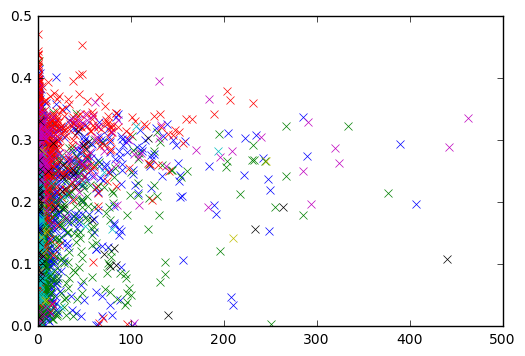

In [18]:
import pickle

nombre_archivo_load = "final_features.p"
caracteristicas = pickle.load( open( nombre_archivo_load , "rb" ) )

def list_of_lists(size):
    new_list=[]
    for i in range(size):
        new_list.append([])
    return new_list

feature_1 = 48
feature_2 = 35 

subclases=EB_subclases
#def sub_class_features(caracteristicas, subclases, feature_1, feature_2):

size_subclases = len(subclases)
subclases_features_2= list_of_lists(size_subclases)
subclases_features_1 = list_of_lists(size_subclases)
c = 0
for j in range(len(caracteristicas[:,0])):
    clase = caracteristicas[j,0]
    if clase in subclases:
        c += 1
        for i in range(len(subclases)):
            if clase == subclases[i]:
                subclases_features_1[i].append(caracteristicas[j,feature_1])
                subclases_features_2[i].append(caracteristicas[j,feature_2])
    
#    return [subclases_features_1, subclases_features_2, c]

print len(subclases_features_1)
#subclases=Cefeids_subclases
#results = sub_class_features(caracteristicas, subclases, feature_1, feature_2)
#print results[2]

ft1 = subclases_features_1
ft2 = subclases_features_2

a, = plt.plot(ft1[0], ft2[0] , 'x')
b, = plt.plot(ft1[1], ft2[1] , 'x')
c, = plt.plot(ft1[2], ft2[2] , 'x')
d, = plt.plot(ft1[3], ft2[3] , 'x')
e, = plt.plot(ft1[4], ft2[4] , 'x')
f, = plt.plot(ft1[5], ft2[5] , 'x')
g, = plt.plot(ft1[6], ft2[6] , 'x')
h, = plt.plot(ft1[7], ft2[7] , 'x')

#plt.axis([0,1, 0, 1.5])

#plt.xlabel("Skew")
#plt.ylabel("Periodo")
#plt.legend([ ab, c], ["RRab","RRc"])
#plt.title("Subclases RR Lyrae")
        #[label, Red_mean, Red_std, Red_MagRatio, Red_amplitude, Blue_mean, Blue_std, 
        #Blue_MagRatio, Blue_amplitude, period]

# RANDOM FOREST

In [3]:
import pickle
nombre_archivo_load = "final_features.p"
caracteristicas = pickle.load( open( nombre_archivo_load , "rb" ) )

"""
red_features = pickle.load( open( 'newfeatures1.p' , "rb" ) )
azul_features = pickle.load( open('azulFeatures.p' , "rb" ))

azul_periodics = pickle.load( open('azul_periodics.p' , "rb" ))
red_periodics =  pickle.load( open('red_periodics.p' , "rb" ))


len_azulf = len(azul_features[0,:])

len_azulp = len(azul_periodics[0,:])

len_redp = len(red_periodics[0,:])

caracteristicas_fake = np.concatenate((red_features, azul_features[:,1:len_azulf]), axis=1)


carac_feik = np.concatenate((caracteristicas_fake, azul_periodics[:,1:len_azulp]), axis = 1)

caracteristicas = np.concatenate((carac_feik, red_periodics[:,1:len_redp]), axis = 1)
"""

"""
# NOMBRES DE CARACTERISTICAS DEL ARCHIVO newfeatures.1.p. A FUTURO SE PIENSA CONCATENAR CARACTERISTICAS EN UNA MATRIX MAYOR
features_names = ['Red_mean', 'Red_std', 'Red_MagRatio', 'Red_amplitude', 'Red_skew', 'Red_kurt', 'Red_quartile31', \
                  'Red_stetson', 'Red_eta', 'Red_cusum', 'Red_shapiro', 'Red_B1std', 'Red_slope_trend', 'B_R', 'period', \
                  'Blue_mean', 'Blue_std', 'Blue_MagRatio', 'Blue_amplitude', 'Blue_skew', 'Blue_kurt', 'Blue_quartile31', \
                  'Blue_stetson', 'Blue_eta', 'Blue_cusum', 'Blue_shapiro', 'Blue_B1std',\
                  'Blue_amplitude', 'Blue_r21', 'Blue_r31', 'Blue_f_phase', 'Blue_phi21', 'Blue_phi31' \
                  'Red_phase_eta', 'Red_slope_per10', 'Red_slope_per90', 'Red_phase_cusum', \
                  'Red_amplitude', 'Red_r21', 'Red_r31', 'Red_f_phase', 'Red_phi21', 'Red_phi31', 'cancer']
"""


features_names= ['Red_weighted_mean','Red_weighted_std','Red_MagRatio','Red_amplitude',\
                  'Red_skew','Red_kurt', 'Red_quartile31', 'Red_stetson', 'Red_eta', 'Red_cusum',\
                  'Red_shapiro', 'Red_B1std', 'Red_hl_amp_ratio', \
                  'Red_phase_eta', 'Red_slope_per10', 'Red_slope_per90','Red_phase_cusum', \
                  'Red_amplitude_f', 'Red_r21', 'Red_r31', 'Red_f_phase', 'Red_phi21', 'Red_phi31', \
                  'Blue_weighted_mean', 'Blue_weighted_std', 'Blue_MagRatio', 'Blue_amplitude',\
                  'Blue_skew','Blue_kurt', 'Blue_quartile31', 'Blue_stetson', 'Blue_eta', 'Blue_cusum',\
                  'Blue_shapiro', 'Blue_B1std','Blue_hl_amp_ratio',\
                  'Blue_phase_eta', 'Blue_slope_per10', 'Blue_slope_per90','Blue_phase_cusum', \
                  'Blue_amplitude_f', 'Blue_r21', 'Blue_r31', 'Blue_f_phase', 'Blue_phi21', 'Blue_phi31', \
                  'B_R', 'period']
    

### Codigo para extraer extraer las subclases de cada una de las tres grandes clases ### 
########################################################################################
subclass = []
for ide in ID_labels:
    label_verify = ID_labels[ide]
    if not (label_verify in subclass):
        subclass.append(label_verify)

RRL_subclases = []
Cefeids_subclases = []
EB_subclases = []

for element in subclass:
    if element[0] == "R":
        RRL_subclases.append(element)   
    elif element[0] == "E":
        EB_subclases.append(element)
    else:
        Cefeids_subclases.append(element) 
           
#####  Rearmar las clases de manera que cada una se codifica con un número 0,1 o 2 ##### 
########################################################################################
        
def three_classes(labels_list):
    RRL = 0
    CEFEIDS = 1
    ECLIPSANTES = 2
    
    new_labels = []
    for etiqueta in labels_list:
        if etiqueta in RRL_subclases:
            new_labels.append(RRL)
        elif etiqueta in Cefeids_subclases:
            new_labels.append(CEFEIDS)
        else:
            new_labels.append(ECLIPSANTES)
    return new_labels


#####      Armar lista de clases a considerar en la clasificación de todas juntas  ##### 
########################################################################################

legit_clases = []
for subclase in RRL_subclases:
    legit_clases.append(subclase)
for subclase in Cefeids_subclases:
    if not (subclase == '13' or subclase == '123' or subclase == 'F12'):
        legit_clases.append(subclase)
for subclase in EB_subclases:
    if not (subclase == 'ED_TEB' or subclase == 'ESD_DPV'):
        legit_clases.append(subclase)
          

#####                     Traspasa los labels a codificación númerica              ##### 
########################################################################################

def all_clases(labels_list):
    
    new_labels = []
    errors = 0
    for etiqueta in labels_list:
        try:
            indice = legit_clases.index(etiqueta)
            new_labels.append(indice)
        except (ValueError):
            errors = errors + 1
            if etiqueta == 'ESD_DPV' or etiqueta == 'ED_TEB':
                index = legit_clases.index('ESD')
            elif etiqueta == '13' or etiqueta == '123' or etiqueta == 'F12': 
                index = legit_clases.index('ED')
            else:
                print "VALUE NOT CONSIDERED"
            new_labels.append(indice)
    
    return new_labels
            
            
only_labels = caracteristicas[:,0]                #Del vector de características generado, extraer columna de labels
big_class_labels = three_classes(only_labels)     #Codificacion para tres grandes clases
all_class_labels = all_clases(only_labels)        #Codificacion para todas las clases juntas



print "Conjunto de todas las clases: "
print legit_clases

Conjunto de todas las clases: 
['RRab', 'RRc', 'RRd', 'RRe', '1', 'F', '12', 'F1', '2', 'ESD', 'ED', 'EC', 'ED_ESD', 'ELL_EC', 'ED_VAR']


C:\Users\Nico\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Feature ranking:
1. Blue_hl_amp_ratio: 0.135727536668
2. period: 0.0914768157859
3. Blue_skew: 0.0751436576058
4. Blue_slope_per10: 0.070773708648
5. Blue_slope_per90: 0.0579879848046
6. Blue_kurt: 0.053476581835
7. Red_slope_per10: 0.0442683182782
8. Blue_quartile31: 0.0373643502115
9. Red_slope_per90: 0.0363263854437
10. Red_kurt: 0.0295850197543
11. Red_hl_amp_ratio: 0.0291266886443
12. Blue_amplitude_f: 0.0268063589227
13. Blue_B1std: 0.0255918541549
14. Blue_weighted_mean: 0.0251117243562
15. Red_weighted_mean: 0.022693202378
16. Blue_r21: 0.0199630769308
17. Red_B1std: 0.0167640635447
18. Red_r21: 0.0132379461742
19. Blue_weighted_std: 0.0132168391489
20. Red_stetson: 0.0131411028252
21. Red_skew: 0.0130192367438
22. Red_phase_eta: 0.0126286976372
23. B_R: 0.0119692232861
24. Blue_shapiro: 0.0105668589169
25. Blue_stetson: 0.0100439969842
26. Blue_MagRatio: 0.00995104012493
27. Blue_phase_eta: 0.00978696177483
28. Blue_r31: 0.00920826426711
29. Red_shapiro: 0.00873289503853
30. B

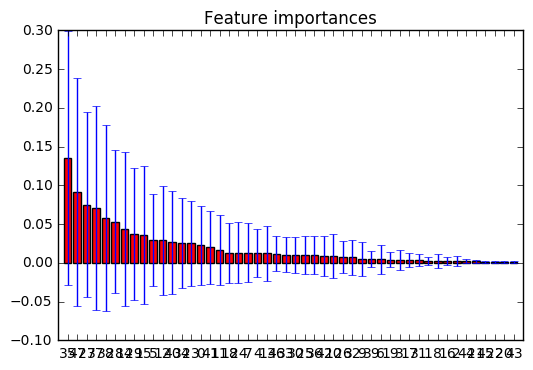

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

N_features = len(caracteristicas[1,:])
X = caracteristicas[:,1:N_features]
Y = big_class_labels

'''
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 2], c=Y, linewidth=0, alpha=0.5, s=20)
plt.grid()
'''

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.25, random_state = True)

clf = RandomForestClassifier(n_estimators=1000, max_depth=None, bootstrap = True, n_jobs = -1)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict_proba(X_test)



importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print str(f+1)+". "+ features_names[indices[f]] + ": "+str(importances[indices[f]])
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()


In [15]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

def prediction(arreglo):
    n_clases = len(arreglo[0])
    pred = []
    for prediccion in arreglo:
        actual_max = 0
        indice_max = 0
        for i, dato in enumerate(prediccion):
            if dato >= actual_max:
                actual_max = dato
                indice_max = i
        pred.append(indice_max)
    return pred
                
#score = metrics.f1_score(y_test, pred, pos_label=list(set(y_test)))
# training score
#score_train = metrics.f1_score(y_train, pred_train, pos_label=list(set(y_train)))

scores_type=None

y_test = Y_test
pred = Y_pred
pred_pscore = prediction(pred)
pscore = metrics.accuracy_score(y_test, pred_pscore)
print "Accuracy: ", pscore

precision_rf = metrics.precision_score(y_test, pred_pscore, average=scores_type)
print "Precision: ", precision_rf

recall_rf = recall_score(y_test, pred_pscore, average=scores_type) 
print "Recall: ", recall_rf

f1_rf = f1_score(y_test, pred_pscore, average=scores_type) 
print "F1 Score: ", f1_rf

'''
scores = cross_val_score(clf, X_test, Y_test)
print "Scores test:", scores.mean()

scores = cross_val_score(clf, X_train, Y_train)
print "Scores train:", scores.mean()

scores = cross_val_score(clf, X, Y)
print "Scores total:", scores.mean()

path = clf.decision_path(X_train)
'''

Accuracy:  0.981645378658
Precision:  [ 0.97930659  0.99191919  0.98243322]
Recall:  [ 0.99090826  0.95201163  0.97591578]
F1 Score:  [ 0.98507326  0.97155578  0.97916365]


'\nscores = cross_val_score(clf, X_test, Y_test)\nprint "Scores test:", scores.mean()\n\nscores = cross_val_score(clf, X_train, Y_train)\nprint "Scores train:", scores.mean()\n\nscores = cross_val_score(clf, X, Y)\nprint "Scores total:", scores.mean()\n\npath = clf.decision_path(X_train)\n'

# Matriz de Confusión


fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 2], c=Y, linewidth=0, alpha=0.5, s=20)
plt.grid()

Confusion matrix, without normalization
[[10746    11    87]
 [   78  1985    40]
 [  180    15  6744]]
Normalized confusion matrix
[[ 0.99  0.    0.01]
 [ 0.04  0.94  0.02]
 [ 0.03  0.    0.97]]


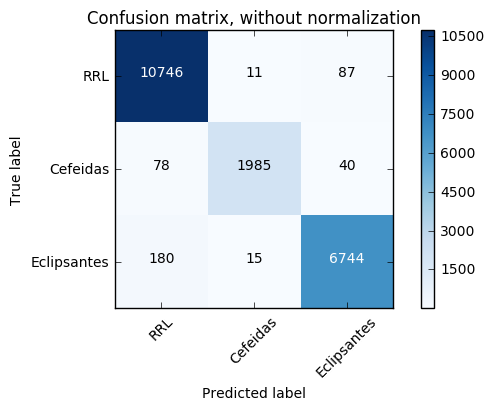

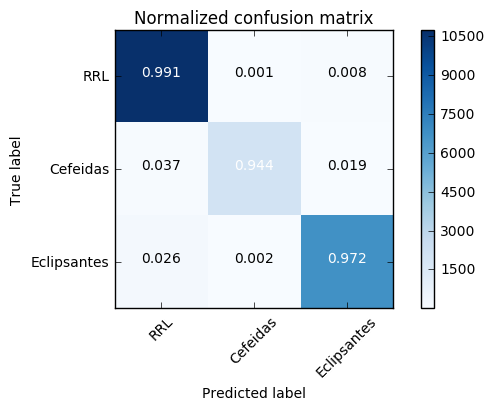

In [6]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


class_names = ['RRL','Cefeidas','Eclipsantes']


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 3)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_pscore)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# RANDOM FOREST TODAS LAS CLASES

Feature ranking:
1. Blue_r21: 0.0573602299534
2. period: 0.0548025910292
3. Blue_hl_amp_ratio: 0.0439445042129
4. Blue_skew: 0.040345461351
5. Blue_phase_eta: 0.0332013638125
6. Blue_slope_per10: 0.0327207226223
7. Red_r21: 0.0326376397599
8. Blue_kurt: 0.0307353943795
9. Blue_stetson: 0.0302470673905
10. Blue_slope_per90: 0.0301236574417
11. Red_weighted_mean: 0.0291726442792
12. Blue_r31: 0.0265784921926
13. Red_phase_eta: 0.0254634397021
14. Blue_amplitude_f: 0.0250606329662
15. Red_slope_per10: 0.0243796222281
16. Red_slope_per90: 0.0238924662319
17. Red_kurt: 0.0222379276737
18. Blue_quartile31: 0.0211798749911
19. Blue_weighted_mean: 0.0210239007174
20. Red_amplitude_f: 0.0208103487507
21. Blue_shapiro: 0.0203073661532
22. Blue_weighted_std: 0.0199561488426
23. Red_skew: 0.0193844135989
24. Blue_B1std: 0.0188242114748
25. Red_r31: 0.0187224641989
26. Red_stetson: 0.0186458131763
27. Red_hl_amp_ratio: 0.0170703550842
28. Blue_amplitude: 0.0169764705043
29. Red_quartile31: 0.016904

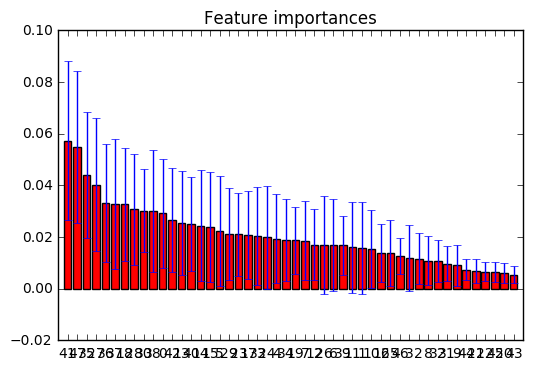

Accuracy: 0.853340517241
Precision:  0.83946187918


In [22]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

N_features = len(caracteristicas[1,:])
X_all = caracteristicas[:,1:N_features]
Y_all = all_class_labels

'''
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 2], c=Y, linewidth=0, alpha=0.5, s=20)
plt.grid()
'''

X_train_all, X_test_all, Y_train_all, Y_test_all = train_test_split(X_all, Y_all, train_size=0.3, random_state = 42)

clf_all = RandomForestClassifier(n_estimators=700, max_depth=None, bootstrap = True, n_jobs=-1, class_weight='balanced_subsample')
clf_all = clf_all.fit(X_train_all, Y_train_all)
Y_pred_all = clf_all.predict_proba(X_test_all)


importances = clf_all.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_all.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_all.shape[1]):
    
    #print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print str(f+1)+". "+ features_names[indices[f]] + ": "+str(importances[indices[f]])
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_all.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_all.shape[1]), indices)
plt.xlim([-1, X_all.shape[1]])
plt.show()

########################3

from sklearn import metrics
from sklearn.metrics import accuracy_score

def prediction(arreglo):
    n_clases = len(arreglo[0])
    pred = []
    for prediccion in arreglo:
        actual_max = 0
        indice_max = 0
        for i, dato in enumerate(prediccion):
            if dato >= actual_max:
                actual_max = dato
                indice_max = i
        pred.append(indice_max)
    return pred
                
#score = metrics.f1_score(y_test, pred, pos_label=list(set(y_test)))
# training score
#score_train = metrics.f1_score(y_train, pred_train, pos_label=list(set(y_train)))

y_test_all = Y_test_all
pred_all = Y_pred_all
pred_pscore_all = prediction(pred_all)

pscore_all = metrics.accuracy_score(y_test_all, pred_pscore_all)
print "Accuracy:", pscore_all

precision_all = metrics.precision_score(y_test_all, pred_pscore_all, average='weighted')
print "Precision: ", precision_all


#scores = cross_val_score(clf_all, X_test_all, y_test_all)
#print "Scores test:", scores.mean()


fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X[:, 0], X[:, 2], c=Y, linewidth=0, alpha=0.5, s=20)
plt.grid()

Confusion matrix, without normalization
Normalized confusion matrix


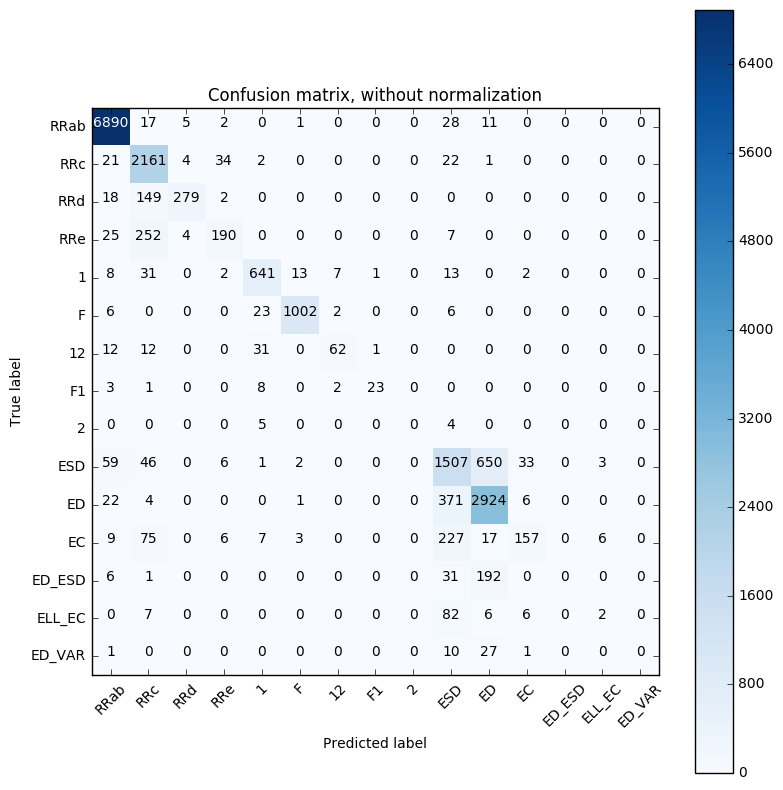

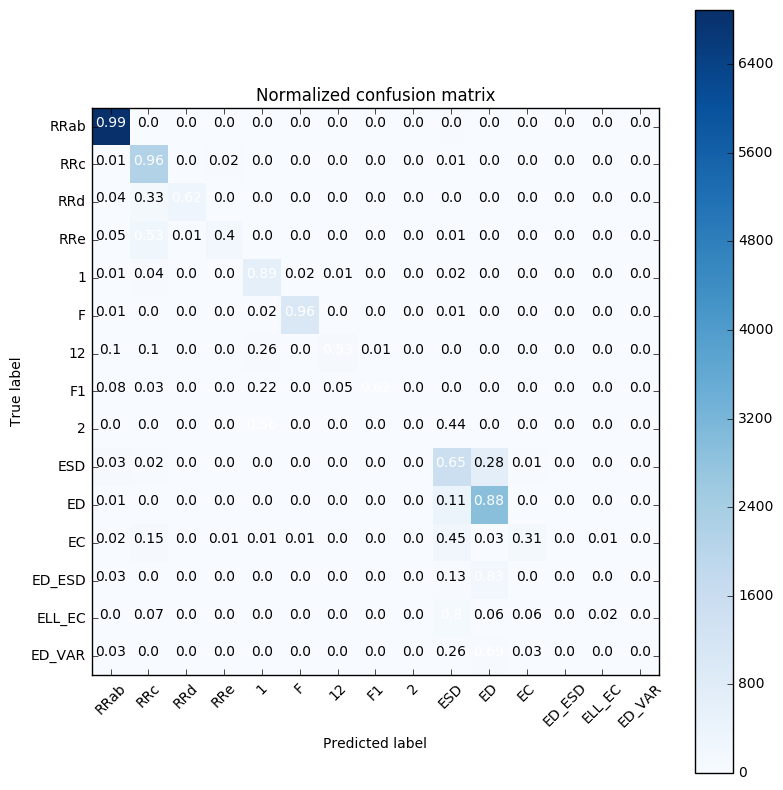

In [23]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = legit_clases


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_all, pred_pscore_all)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [16]:
print len(caracteristicas[0])
print len(features_names)

49
48
